## Dataset define

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd

df_train = pd.read_csv("/content/imdb_train.csv")
df_val = pd.read_csv("/content/imdb_validation.csv")
df_test = pd.read_csv("/content/imdb_test.csv")

print("Train samples:", len(df_train))
print("Validation samples:", len(df_val))
print("Test samples:", len(df_test))
print("Total samples:", len(df_train) + len(df_val) + len(df_test))

Train samples: 34707
Validation samples: 9916
Test samples: 4959
Total samples: 49582


In [4]:
df_train.head()

,text,label
0,Anarchy and lawlessness reign supreme in the p...,1
1,"Before I begin, a ""little"" correction: IMDb st...",0
2,"You know Jason, you know Freddy, and you know ...",0
3,Creative use of modern and mystical elements: ...,1
4,"In the trivia section for Pet Sematary, it men...",1


## Model define

In [5]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### dataset and dataloader split

In [7]:
from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=256):
        self.texts = dataframe["text"].tolist()
        self.labels = dataframe["label"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


In [10]:
from transformers import AutoTokenizer

batch_size = 16
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_dataset = IMDBDataset(df_train, tokenizer)
val_dataset = IMDBDataset(df_val, tokenizer)
test_dataset = IMDBDataset(df_test, tokenizer)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))
print("Total samples:", len(train_dataset) + len(val_dataset) + len(test_dataset))

Train samples: 34707
Validation samples: 9916
Test samples: 4959
Total samples: 49582


In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print("Number of batches in train_dataloader:", len(train_dataloader))
print("Number of batches in val_dataloader:", len(val_dataloader))
print("Number of batches in test_dataloader:", len(test_dataloader))

Number of batches in train_dataloader: 2170
Number of batches in val_dataloader: 620
Number of batches in test_dataloader: 310


### optimizer and loss set

In [12]:
from transformers import get_scheduler
from torch.optim import AdamW
import torch

optimizer = AdamW(model.parameters(), lr=2e-5)

# 使用 GPU 如果可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 训练步数
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)

# 学习率调度器（线性 warmup）
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [13]:
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

loss_fn = CrossEntropyLoss()

## Train and evaluate

### train function

In [14]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score


def train(model, train_dataloader, val_dataloader, optimizer, lr_scheduler, device, num_epochs=3):
    model.train()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        total_loss = 0
        all_preds = []
        all_labels = []

        # Training Loop
        model.train()
        loop = tqdm(train_dataloader, desc="Training")

        for batch in loop:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            # Backward
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Metrics
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(batch['labels'].detach().cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds)

        print(f"Train Loss: {total_loss:.4f} | Accuracy: {train_acc:.4f} | F1: {train_f1:.4f}")

        # Validation Loop
        evaluate(model, val_dataloader, device)


@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(batch['labels'].detach().cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"Validation Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")

In [15]:
train(model, train_dataloader, val_dataloader, optimizer, lr_scheduler, device, num_epochs=3)


Epoch 1/3


Training: 100%|██████████| 2170/2170 [25:48<00:00,  1.40it/s]


Train Loss: 540.5145 | Accuracy: 0.8970 | F1: 0.8972
Validation Accuracy: 0.9165 | F1 Score: 0.9199

Epoch 2/3


Training: 100%|██████████| 2170/2170 [25:50<00:00,  1.40it/s]


Train Loss: 273.5464 | Accuracy: 0.9538 | F1: 0.9538
Validation Accuracy: 0.9281 | F1 Score: 0.9280

Epoch 3/3


Training: 100%|██████████| 2170/2170 [25:54<00:00,  1.40it/s]


Train Loss: 108.0260 | Accuracy: 0.9846 | F1: 0.9846
Validation Accuracy: 0.9277 | F1 Score: 0.9286


### test function

In [16]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

@torch.no_grad()
def final_evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"✅ Test Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg", "pos"], yticklabels=["neg", "pos"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

✅ Test Accuracy: 0.9250 | F1 Score: 0.9266


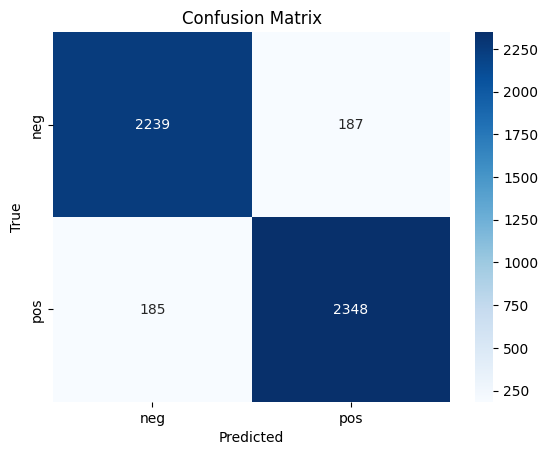

In [17]:
final_evaluate(model, test_dataloader, device)

## Save model and tokenizer

In [18]:
torch.save(model.state_dict(), "bert_base.pt")

# from transformers import BertForSequenceClassification

# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
# model.load_state_dict(torch.load("bert_sentiment.pt", map_location=device))
# model.to(device)
# model.eval()


tokenizer.save_pretrained("bert_base_tokenizer/")

# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("bert_tokenizer/")

('bert_base_tokenizer/tokenizer_config.json',
 'bert_base_tokenizer/special_tokens_map.json',
 'bert_base_tokenizer/vocab.txt',
 'bert_base_tokenizer/added_tokens.json',
 'bert_base_tokenizer/tokenizer.json')